In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [96]:
from math import ceil
from functools import partial
from pathlib import Path
import json
import itertools
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import cartopy.crs as ccrs
import xarray as xr
import cf_xarray as cfxr
import dask.array
import cftime
import scipy
import cfr
import cmocean

from lmrecon.io import IntakeESMLoader, save_mfdataset, open_mfdataset
from lmrecon.plotting import plot_field, format_plot, save_plot, add_subplot_headers, get_field_label
from lmrecon.util import get_data_path, get_position_coords, unstack_state, stack_state, add_cartesian_coords
from lmrecon.signal import compute_spectrum_multitaper, compute_spharm_spectrum_multitaper
from lmrecon.logger import logging_disabled
from lmrecon.eof import EOF
from lmrecon.lim import LIM
from lmrecon.time import month_name, map_decimal_to_season, use_tuple_time_coords, Season, use_decimal_year_time_coords
from lmrecon.stats import area_weighted_mean

In [48]:
ds = xr.open_zarr("/home/enkf6/dstiller/lmrecon/cmip6/MPI-ESM1-2-LR/past2k/seasonal_anomalies.zarr")
# ds = xr.open_zarr("/home/enkf6/dstiller/lmrecon/cmip6/MRI-ESM2-0/past1000/seasonal_anomalies.zarr")
ds = ds.isel(time=slice(-4*100, None))
ds = use_tuple_time_coords(ds)
ds = ds.compute()
ds

<xarray.Dataset> Size: 311MB
Dimensions:  (time: 400, lat: 90, lon: 180)
Coordinates:
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) object 3kB MultiIndex
  * year     (time) int64 3kB 1751 1751 1751 1751 1752 ... 1850 1850 1850 1850
  * season   (time) object 3kB Season.DJF Season.MAM ... Season.JJA Season.SON
Data variables:
    cldhigh  (time, lat, lon) float32 26MB 0.03179 0.03209 ... -0.05896 -0.05763
    cldlow   (time, lat, lon) float32 26MB 0.0 0.0 0.0 ... 0.1161 0.1167 0.1171
    clwvi    (time, lat, lon) float32 26MB -0.0002787 -0.000291 ... 0.002432
    ohc700   (time, lat, lon) float32 26MB nan nan nan ... 2.633e+09 2.635e+09
    psl      (time, lat, lon) float32 26MB -25.4 -25.88 -26.34 ... -590.3 -590.2
    rlut     (time, lat, lon) float32 26MB -1.095 -1.139 -1.185 ... -1.731 -1.59
    rsut     (time, lat, lon) float32 26MB 1.36 1.359 1.295 ... -0.9374 -0.9452
    siconc   (time, lat, lon) float32 26MB nan nan nan ... 0.01569 0.01519
    tas      (time, lat, lon) float32 26MB -0.2272 -0.2449 ... 0.2489 0.2237
    tos      (time, lat, lon) float32 26MB nan nan nan ... -0.0001526 -0.0001526
    zg500    (time, lat, lon) float32 26MB -4.932 -4.994 -5.033 ... -65.2 -65.21
    zos      (time, lat, lon) float32 26MB nan nan nan ... -0.1136 -0.1125

In [7]:
pd.Series(ds.season).value_counts()

Season.MAM    1800
Season.JJA    1800
Season.SON    1800
Season.DJF    1799
Name: count, dtype: int64

In [8]:
seasons = [Season.DJF, Season.MAM, Season.JJA, Season.SON]
seasons

[<Season.DJF: 0>, <Season.MAM: 1>, <Season.JJA: 2>, <Season.SON: 3>]

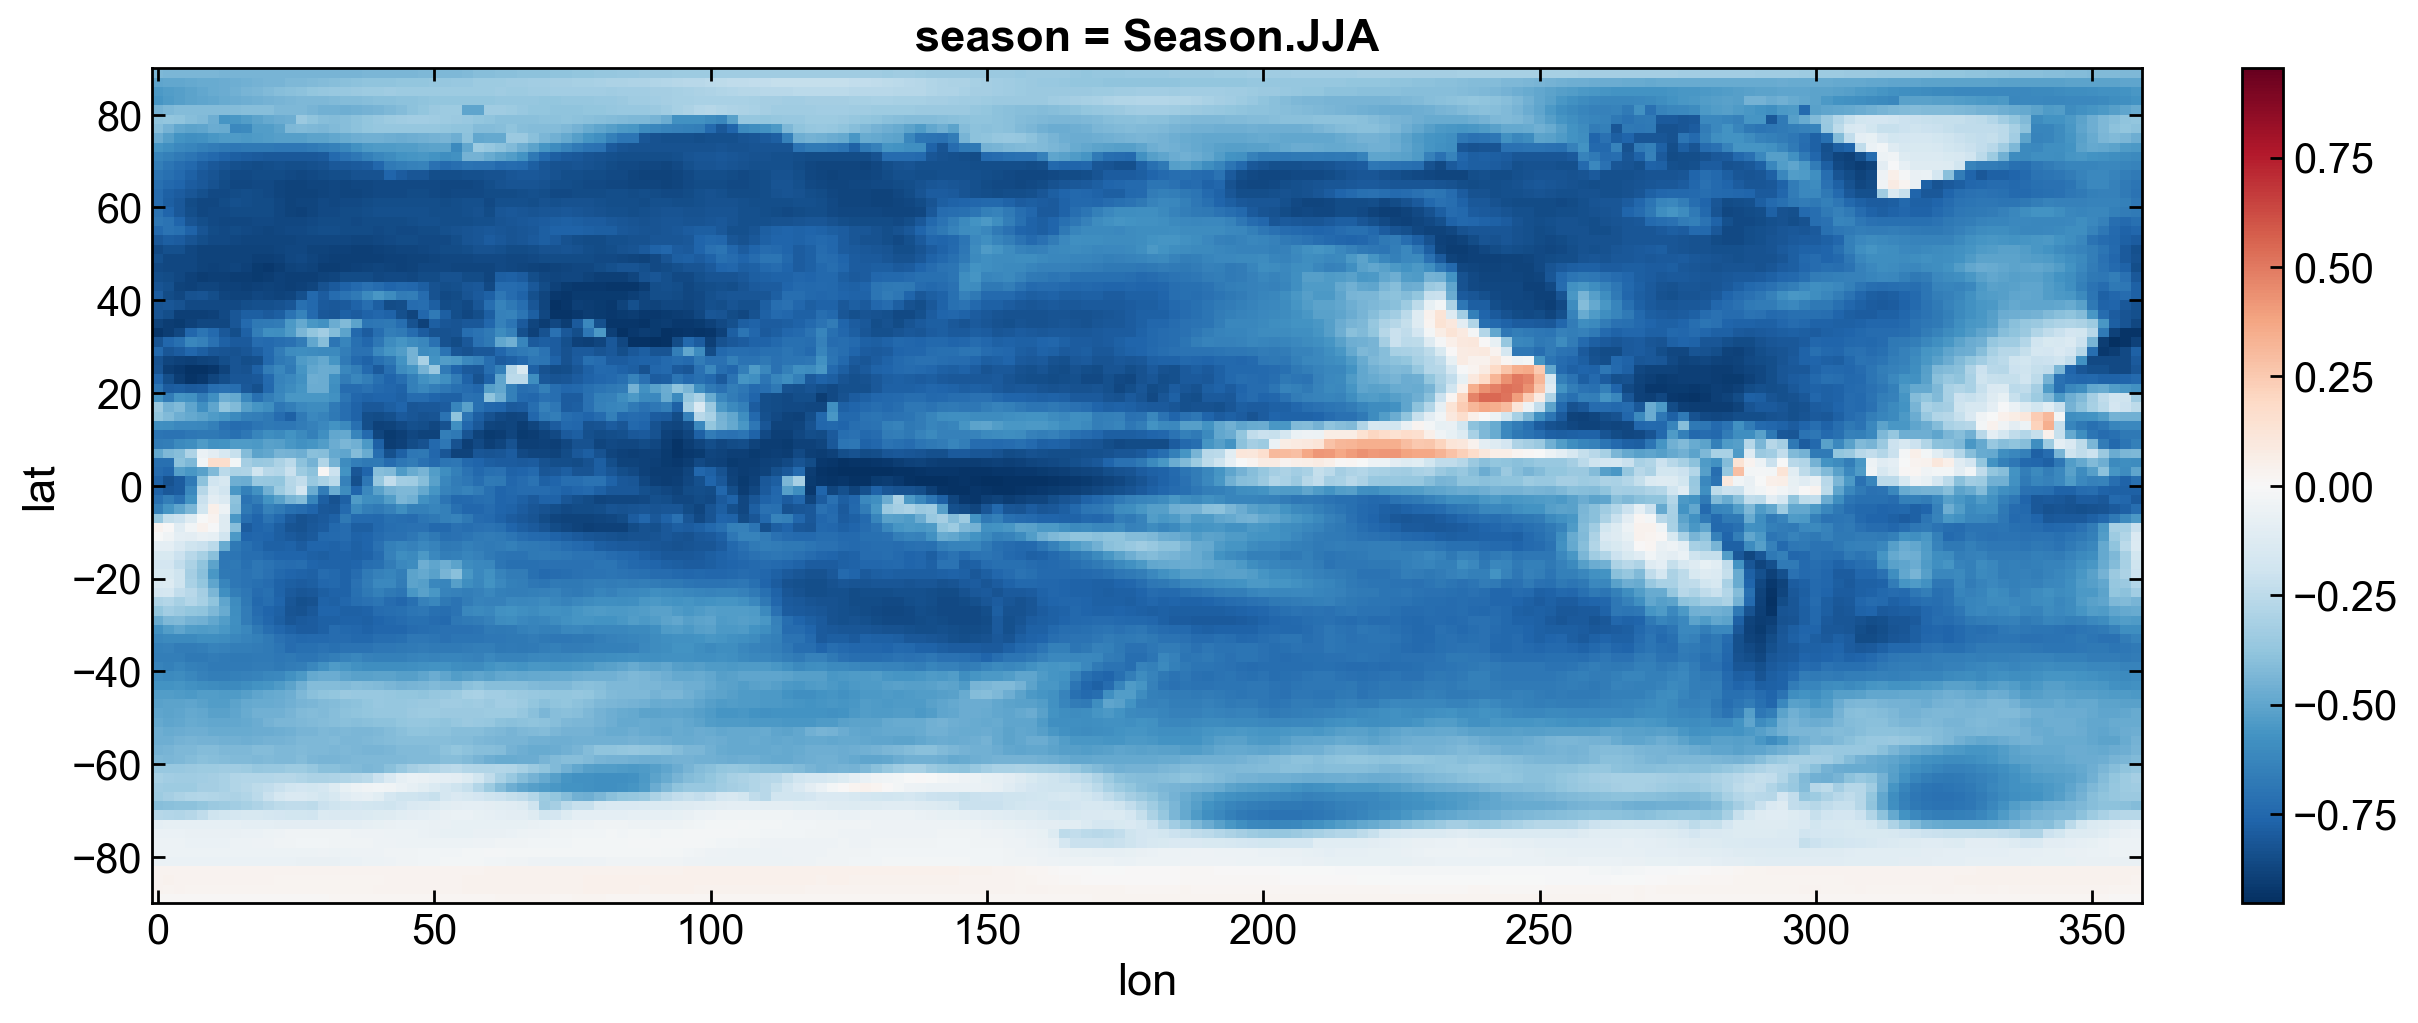

In [9]:
xr.corr(ds["rsut"].sel(season=Season.JJA), ds["rlut"].sel(season=Season.JJA), "year").plot()

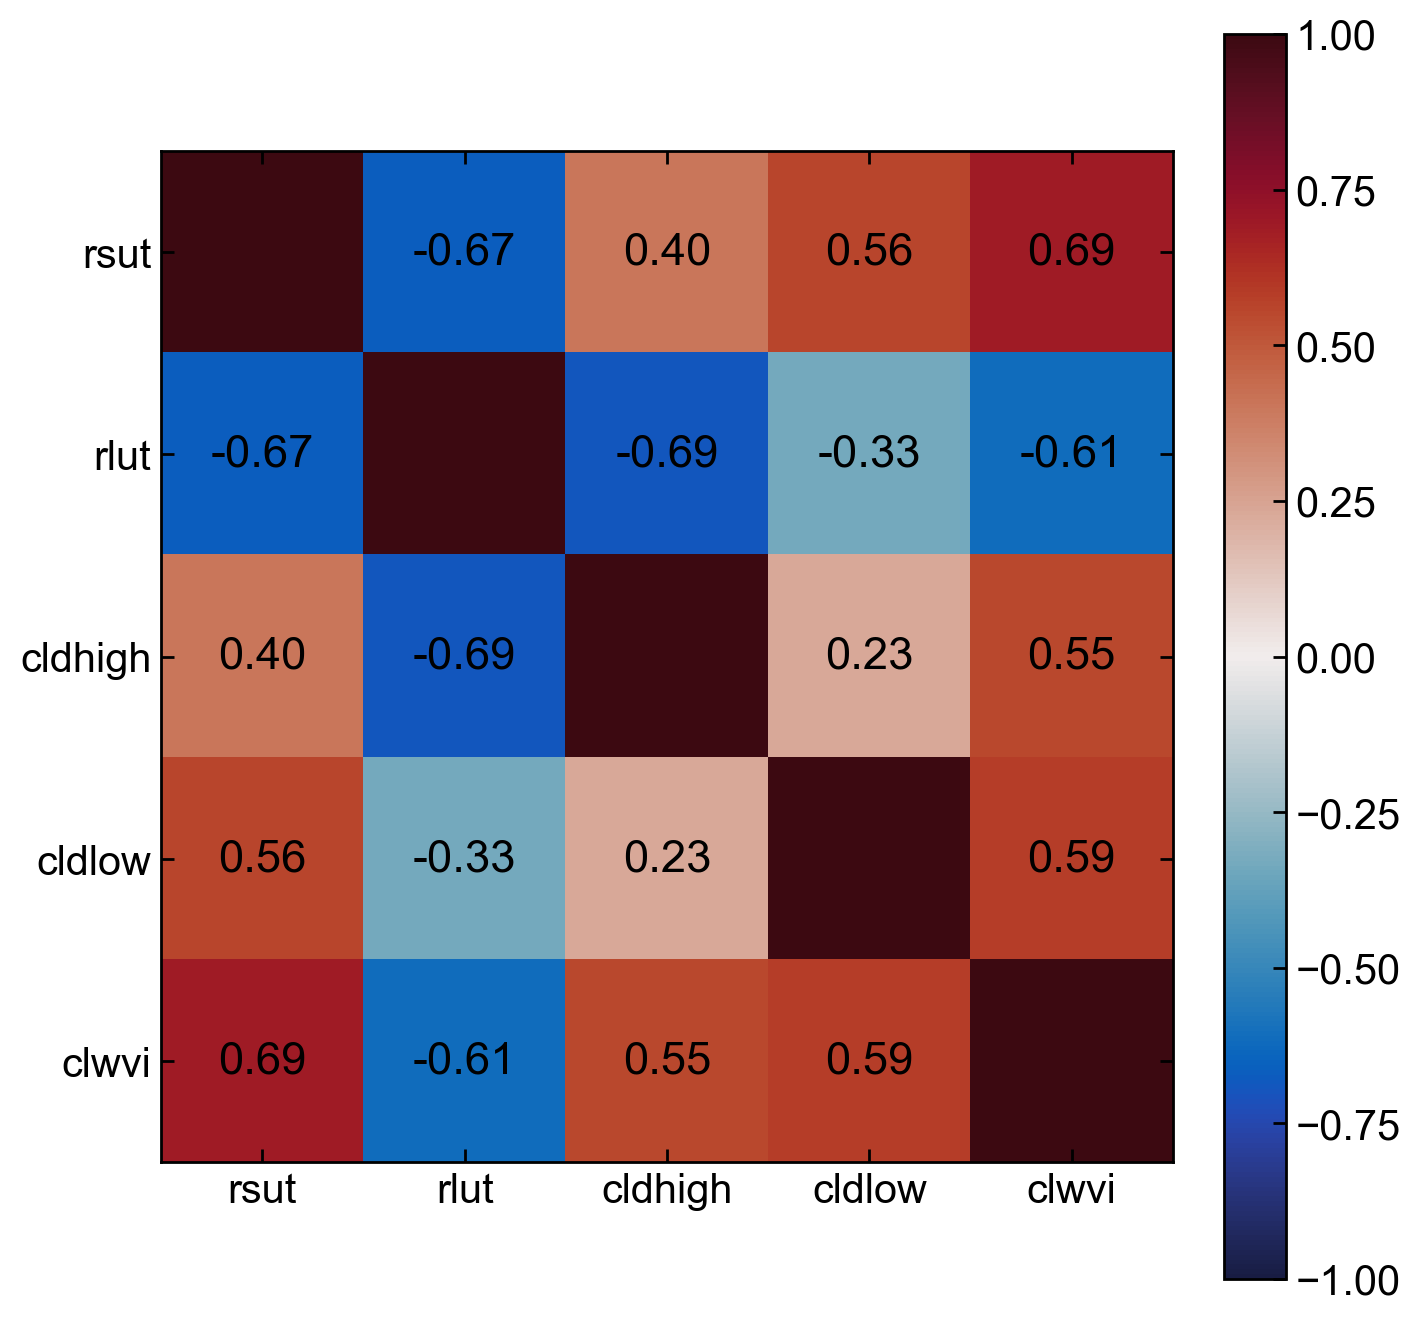

In [ ]:
def plot_correlations(fields=["tas", "tos", "rsut", "rlut", "ohc700"], abs=False):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    
    corrs = []

    for f1, f2 in itertools.product(fields, fields):
        if abs:
            corrs.append(area_weighted_mean(np.abs(xr.corr(ds[f1], ds[f2], "time"))))
        else:
            corrs.append(area_weighted_mean(xr.corr(ds[f1], ds[f2], "time")))
    corrs = np.array(corrs).reshape(len(fields), len(fields))

    if abs:
        pos = ax.imshow(corrs, vmin=0, vmax=1, cmap=cmocean.cm.amp)
    else:
        pos = ax.imshow(corrs, vmin=-1, vmax=1, cmap=cmocean.cm.balance)
    ax.set_xticks(range(len(fields)), fields)
    ax.set_yticks(range(len(fields)), fields)

    for i in range(corrs.shape[0]):
        for j in range(corrs.shape[1]):
            if i == j:
                continue
            ax.text(j, i, f"{corrs[i, j]:.2f}",
                    ha='center', va='center', color='black')
    

    fig.colorbar(pos, shrink=0.9)

# plot_correlations()
plot_correlations(["rsut", "rlut", "cldhigh", "cldlow", "clwvi"], abs=False)

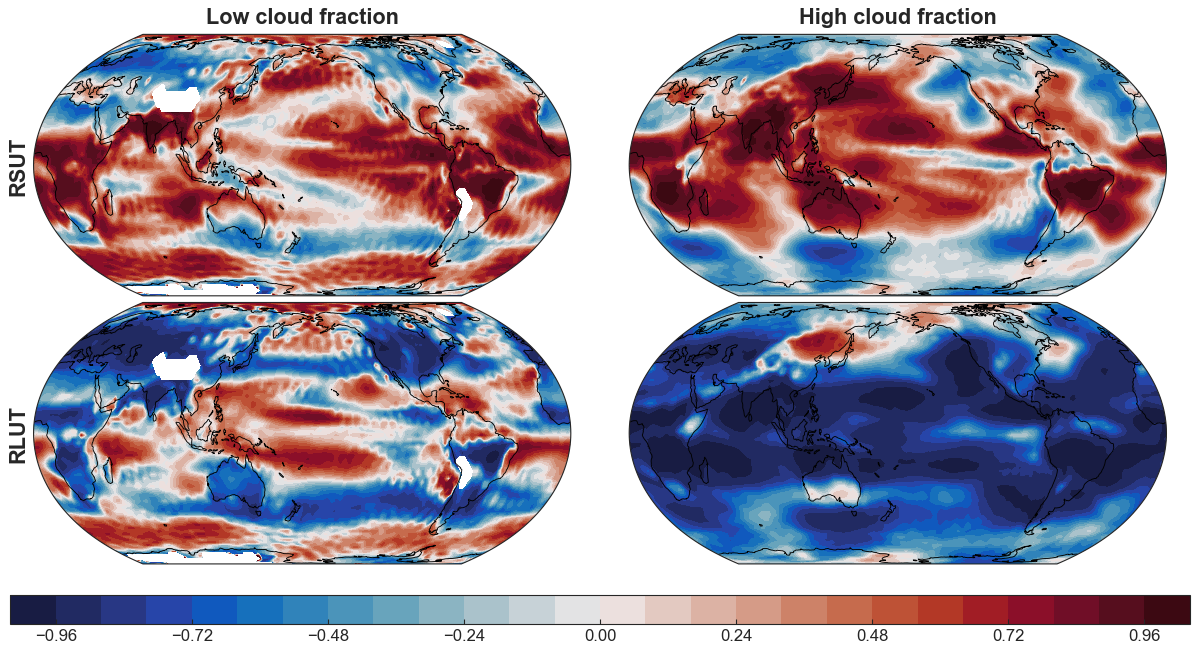

In [51]:
def plot_cloud_radiation_correlation(season=None):
    fig, axs = plt.subplots(2, 2, figsize=(2 * 7.5, 2 * 4), dpi=80, subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=180)))

    if season:
        ds_season = ds.sel(season=season).rename(year="time")
    else:
        ds_season = ds
    
    plot_field(axs.flatten(), [
        xr.corr(ds_season["rsut"], ds_season["cldlow"], "time"),
        xr.corr(ds_season["rsut"], ds_season["cldhigh"], "time"),
        xr.corr(ds_season["rlut"], ds_season["cldlow"], "time"),
        xr.corr(ds_season["rlut"], ds_season["cldhigh"], "time"),
    ], n_level=30, vmin=-1, vmax=1, cmap=cmocean.cm.balance, extend="neither", cbar_aspect=40)

    for ax in axs.flat:
        ax.coastlines()
    
    add_subplot_headers(["RSUT", "RLUT"], ["Low cloud fraction", "High cloud fraction"])

plot_cloud_radiation_correlation()

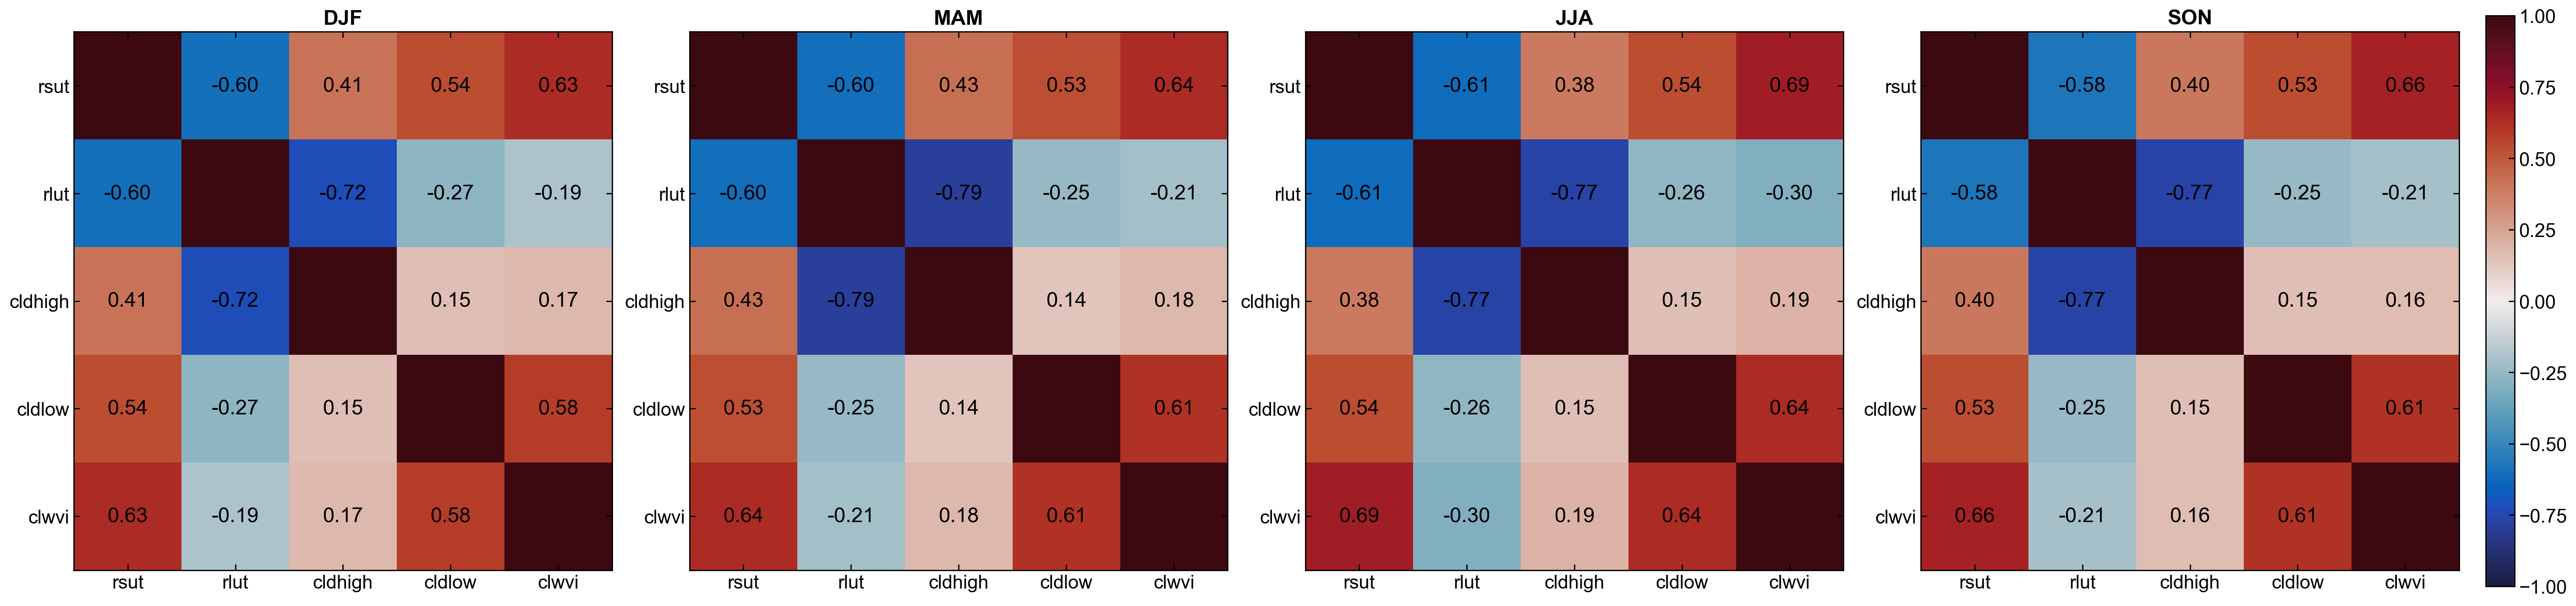

In [10]:
def plot_seasonal_correlations(fields=["tas", "tos", "rsut", "rlut", "ohc700"], abs=False):
    fig, axs = plt.subplots(1, 4, figsize=(7 * 4, 7))
    
    for ax, season in zip(axs, seasons):
        corrs = []
        ds_season = ds.sel(season=season)

        for f1, f2 in itertools.product(fields, fields):
            if abs:
                corrs.append(area_weighted_mean(np.abs(xr.corr(ds_season[f1], ds_season[f2], "year"))))
            else:
                corrs.append(area_weighted_mean(xr.corr(ds_season[f1], ds_season[f2], "year")))
        corrs = np.array(corrs).reshape(len(fields), len(fields))

        pos = ax.imshow(corrs, vmin=-1, vmax=1, cmap=cmocean.cm.balance)
        ax.set_xticks(range(len(fields)), fields)
        ax.set_yticks(range(len(fields)), fields)

        for i in range(corrs.shape[0]):
            for j in range(corrs.shape[1]):
                if i == j:
                    continue
                ax.text(j, i, f"{corrs[i, j]:.2f}",
                        ha='center', va='center', color='black')
        ax.set_title(season.name)
    

    fig.colorbar(pos, shrink=0.9)

# plot_seasonal_correlations()
plot_seasonal_correlations(["rsut", "rlut", "cldhigh", "cldlow", "clwvi"], abs=False)

In [8]:
xr.concat([ds.sel(season=season).var("year").sum() for season in seasons], dim="season")

<xarray.Dataset> Size: 352B
Dimensions:  (season: 4)
Coordinates:
  * season   (season) object 32B Season.DJF Season.MAM Season.JJA Season.SON
Data variables:
    ohc700   (season) float64 32B 8.1e+21 8.134e+21 9.149e+21 8.487e+21
    pr       (season) float64 32B 1.433e-06 1.217e-06 1.322e-06 1.256e-06
    psl      (season) float64 32B 1.285e+09 1.068e+09 1.393e+09 9.684e+08
    rlut     (season) float64 32B 4.705e+05 4.435e+05 5.044e+05 5.326e+05
    rsut     (season) float64 32B 6.845e+05 6.308e+05 1.009e+06 9.693e+05
    sos      (season) float64 32B 0.001161 0.0009977 0.001183 0.001056
    tas      (season) float64 32B 2.557e+04 2.022e+04 2.019e+04 1.859e+04
    tos      (season) float64 32B 3.338e+03 3.204e+03 3.683e+03 2.819e+03
    zg500    (season) float64 32B 1.676e+07 1.33e+07 1.602e+07 1.191e+07
    zos      (season) float64 32B 19.03 17.79 18.13 17.83

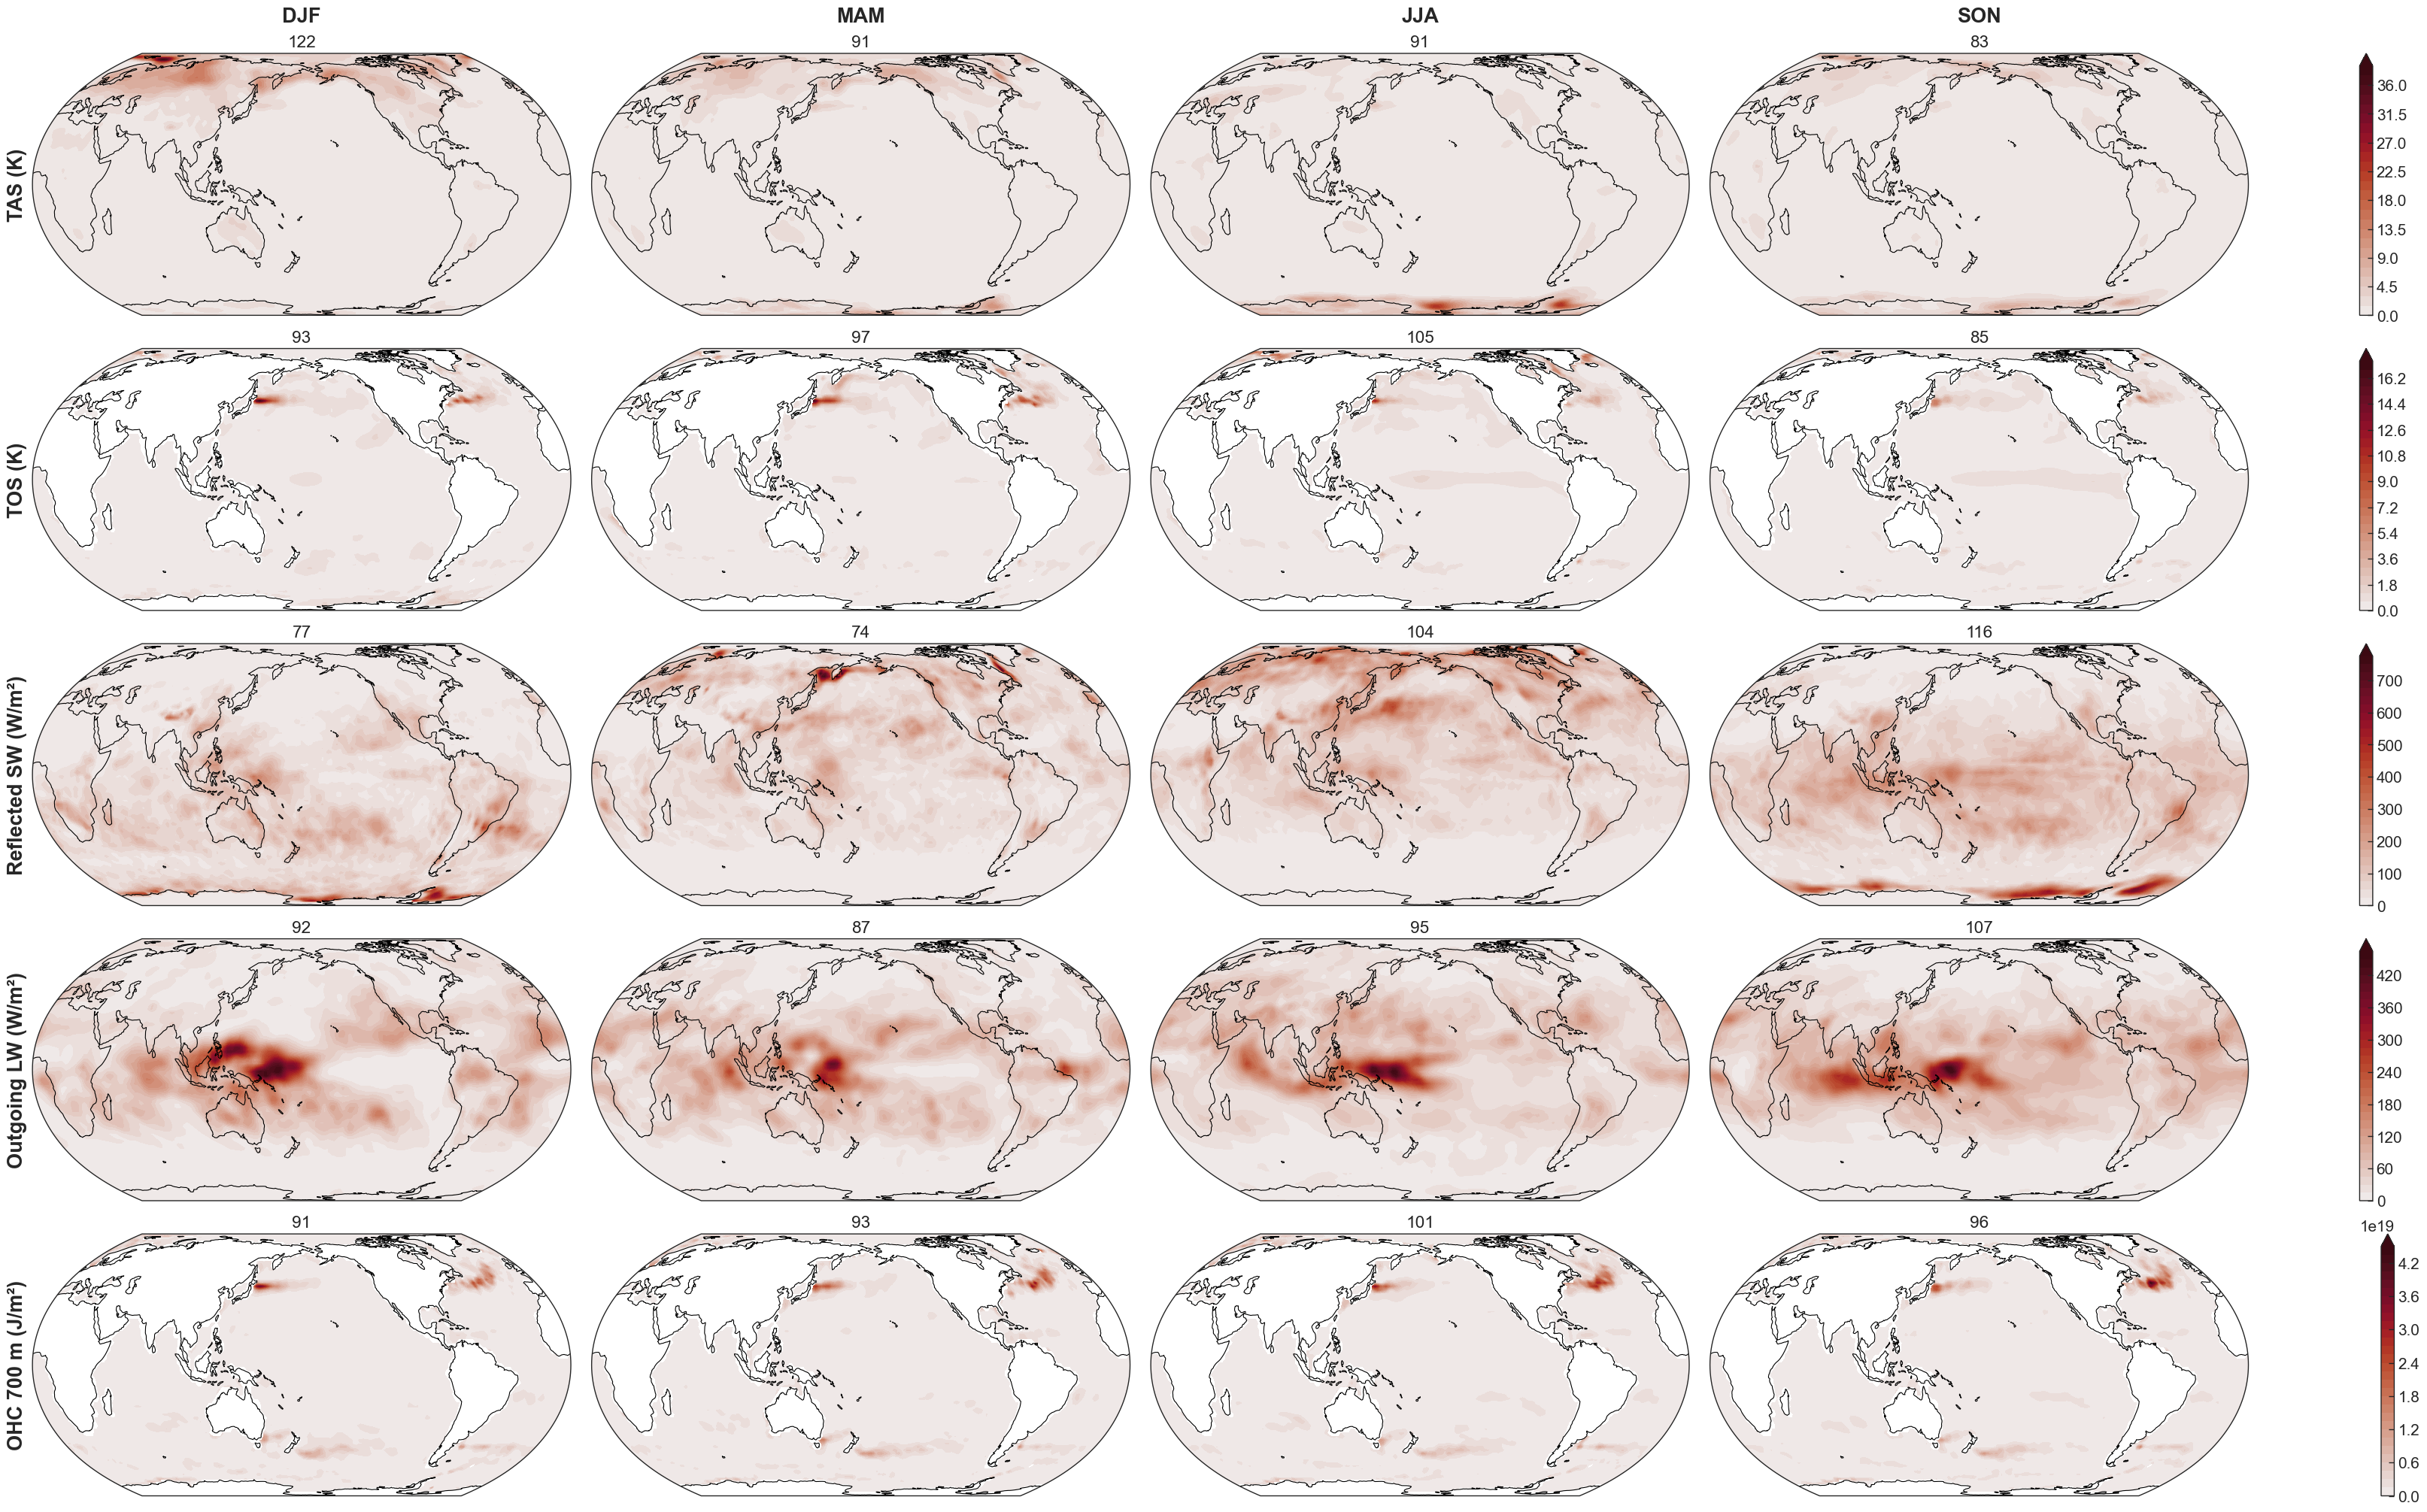

In [42]:
def plot_variance_by_season(fields=["tas", "tos", "rsut", "rlut", "ohc700"]):
    fig, axs = plt.subplots(len(fields), 4, figsize=(8 * 4, 4 * len(fields)), dpi=100, subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=180)))

    for i, field in enumerate(fields):
        axs_row = axs[i, :]

        for ax, season in zip(axs_row, seasons):
            var = ds[field].sel(season=season).var("year").weighted(np.cos(np.radians(ds["lat"]))).sum() / ds[field].var("time").weighted(np.cos(np.radians(ds["lat"]))).sum()
            ax.set_title(f"{var*100:.0f}", fontweight="normal")

        plot_field(axs_row, [
            ds[field].sel(season=season).var("year") for season in seasons
        ], n_level=30, cbar_orientation="vertical", vmin=0, cmap=cmocean.cm.amp, extend="max")
    
    for ax in axs.flat:
        ax.coastlines()

    add_subplot_headers([get_field_label(field) for field in fields], [season.name for season in seasons], col_pad=30)

plot_variance_by_season()

<Axes: xlabel='Wavelength [km]', ylabel='Power [K$^2$ / spharm degree]'>

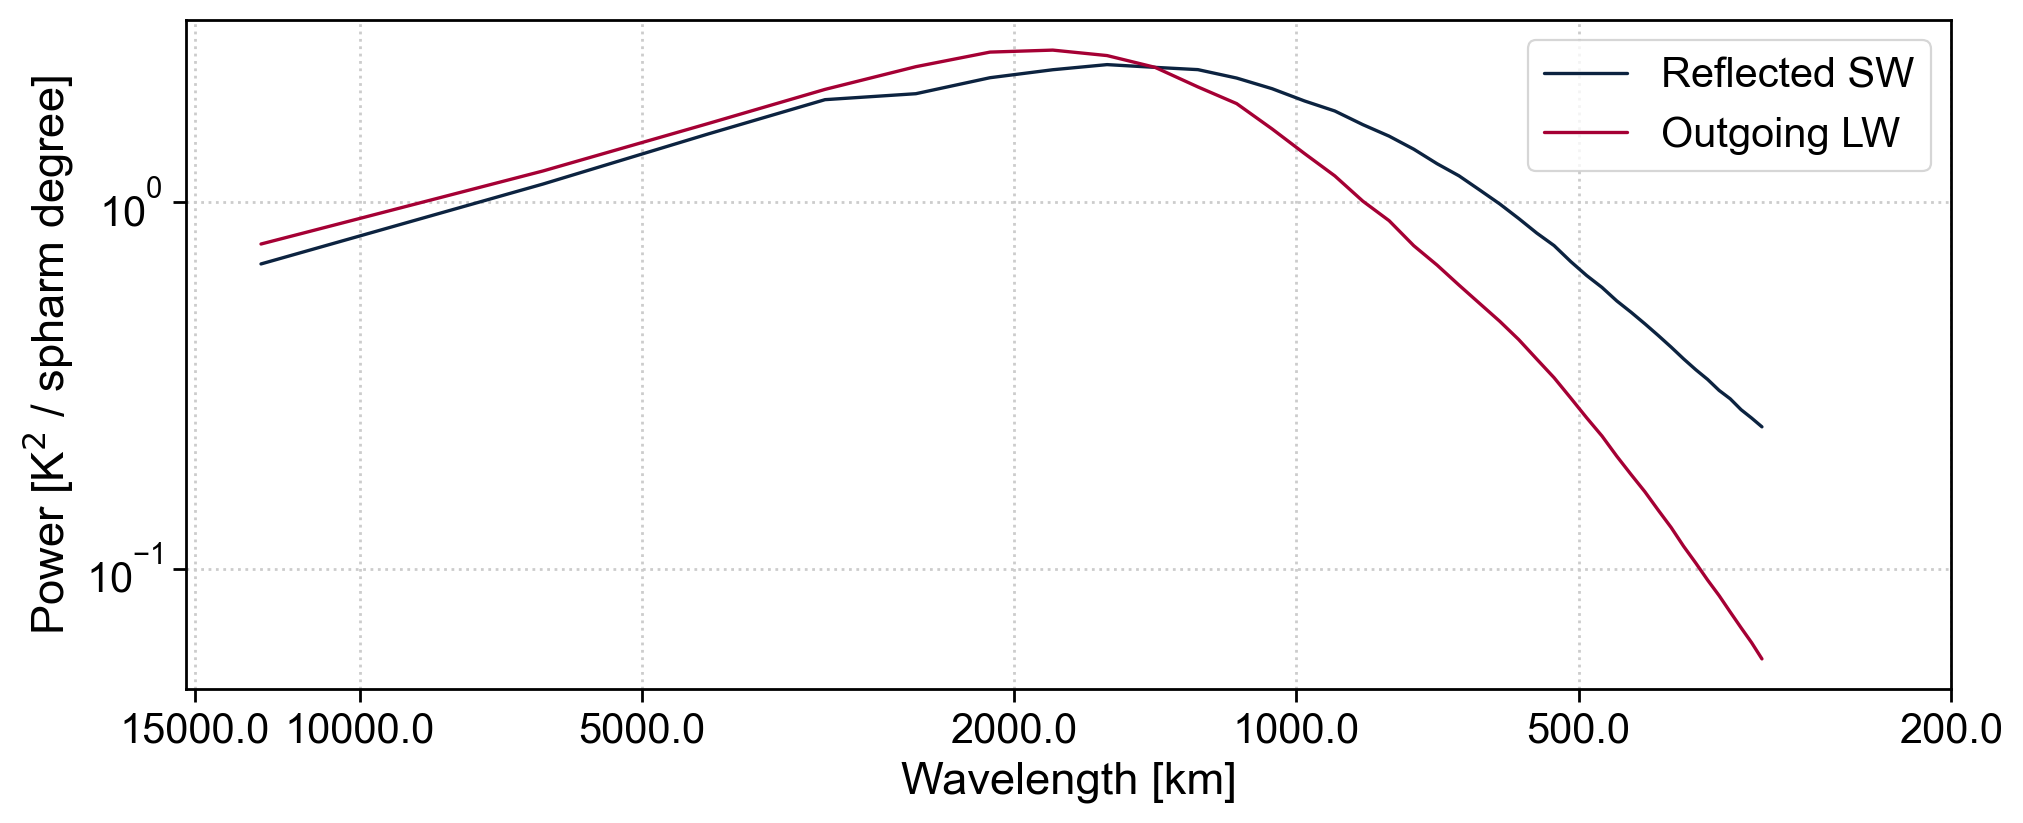

In [109]:
def plot_spharm_spectrum():
    # Spectrum of zonal variations, summed over lons and averaged over timed
    fig, ax = plt.subplots(figsize=(10, 4))

    for field in ["rsut", "rlut"]:
        psd = compute_spharm_spectrum_multitaper(ds[field].isel(time=slice(20))).mean("time").sel(degree=slice(1, None))
        ax.plot(psd.degree, psd, label=get_field_label(field, False))
    # Not 100% sure about units
    ax.set_ylabel("Power [K$^2$ / spharm degree]")

    ax.set_xlabel("Wavelength [km]")
    ax.set_yscale("log")
    ax.set_xscale("log")

    ax.legend()

    format_plot(major_grid=True)
    ticks = [15e3, 10e3, 5e3, 2e3, 1e3, 5e2, 2e2]
    ax.set_xticks([6371 * 2 / t for t in ticks], ticks)

    return ax

plot_spharm_spectrum()